# What is the image moment (or how to fit and ellipse)

A moment (M) is a specific quantitative measure of a given distribution. The distribution can be one or multi-dimensional. That is the [wikipeda definition](https://en.wikipedia.org/wiki/Moment_(mathematics).

Now let's try to have an intuitive view of what it is in the case of an image.

Remember that an image is only a 2D distribution of a set of points. Each point being localized by two coordinates $x$ and $y$. So fo each pixel we have the following $f(x, y) = I_{x, y}$. Where $I_{x, y}$ corresponds to the intensity at the coordinate $x$ and $y$. 

Before going to intuition let's do some easy math. The formal definition of the image moment (2D and continuous) is:

$$M_{pq} = \int_{-\infty}^{\infty} x^p y^q f(x, y) dx dy$$

And the 2D discrete equation is : 

$$M_{pq} = \sum_x \sum_y x^p y^q I(x,y)$$

So we see here that the moment (M) depends on two parameters $p$ and $q$. They are called **the order** of the moment. Different order will give a different **measure** of the distribution we are looking at.

For example let's define a simple 1D distribution of length $N$ $f(x) = A$.

- the zero order ($p=0$) moment of $A$ is **the number of element** : $M_0 = \sum_x x^0 = len(A)$ (for pythonist)
- the first order ($p=1$) moment of a $A$ if the **sum** of all the element : $M_1 = \sum_x x^1 = np.sum(A)$ (for pythonist)

Now if we divide the first order moment by the zero order moment we have the mean : 

$$\bar{A} = \frac{1}{N} \sum_x x = \frac{M_1}{M_0}$$

## The image moment 

Now let's try to apply this 1D example to an image.

[0 1]


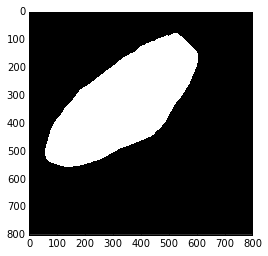

In [13]:
# Do some import
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tifffile import TiffFile

# Load the image
tf = TiffFile("binary_cell.tif")

# Get the numpy array
a = tf.asarray()

# Replace all 255 to 1 so the image is now made of "0" and "1"
a[a == 255] = 1
print(np.unique(a))

_ = plt.imshow(a, interpolation="none", cmap="gray")

The goal here is to use the image moment to **fit an ellipse**. The ellipse can be defined by three parameters : the center, the major axis and the minor axis.

### Find the centroid

First we are going to detect the centroid (the center of the ellipse) of our object by computing the zero and first order of the image.

Remember the discrete equation : 

$$M_{pq} = \sum_x \sum_y x^p y^q I(x,y)$$

Since we are working on a binary image (only $0$ and $1$) values we remove $I(x,y)$.

The zero order moment is then :

$$M_{00} = \sum_x \sum_y x^0 y^0$$


Let's do it in python.

In [17]:
# The sum of all value of 1
M_00 = np.sum(a)
M_00

142369

Now let's compute the first order moment for $x$ :

$$M_{10} = \sum_x \sum_y x^1 y^0$$

In [19]:
# Here we get all the coordinates of pixel equal to 1
xx, yy = np.where(a == 1)

M_10 = np.sum(xx)
M_10

46616805

Now let's compute the first order moment for $y$ :

In [20]:
M_01 = np.sum(yy)
M_01

48021475

So the centroid $C$ is given by :


$$C_x = \bar{x} = \frac{M_{10}}{M_{00}}$$

$$C_y = \bar{y} = \frac{M_{01}}{M_{00}}$$

In [23]:
C_x = M_10 / M_00
C_y = M_01 / M_00
print("C =", (C_x, C_y))

C = (327.43648547085388, 337.30288897161603)


Let's verify it visually :

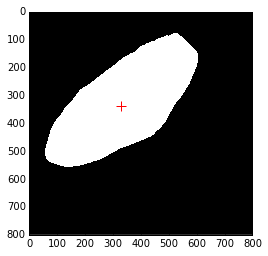

In [27]:
plt.scatter(C_x, C_y, color='red', marker='+', s=100)
_ = plt.imshow(a, interpolation="none", cmap="gray")

Well it seems to work nicely !

### Find the major and minor axis

Here it becomes a little bit tricky.

The information about the object orientation can be derived using the **second order central moments** to construct a **covariance matrix** (see [Wikipedia](https://en.wikipedia.org/wiki/Image_moment) for more details).

Here is a new concept : **central moment** ($\mu$) which describes **distribution of mean** (unlike moment (M) which describes distribution only).

Note that sometime moment is also called **raw moment**.

The discrete equation of the central moment is the : 

$$\mu_{pq} = \sum_{x} \sum_{y} (x - \bar{x})^p(y - \bar{y})^q f(x,y)$$

with $\bar{x}=\frac{M_{10}}{M_{00}}$ and $\bar{y}=\frac{M_{01}}{M_{00}}$

Now it becomes difficult to get the intuition of what's going next. From [Wikipedia](https://en.wikipedia.org/wiki/Image_moment) :  

> The eigenvectors of the covariance matrix of the image correspond to the **major** and **minor** axes of the image intensity, so the orientation can thus be extracted from the **angle of the eigenvector** associated with the **largest eigenvalue**. It can be shown that this angle Θ is given by the following formula:

> $$\Theta = \frac{1}{2} \arctan \left( \frac{2\mu'_{11}}{\mu'_{20} - \mu'_{02}} \right)$$

Where :

$$\mu'_{20} = \mu_{20} / \mu_{00} = M_{20}/M_{00} - \bar{x}^2$$
$$\mu'_{02} = \mu_{02} / \mu_{00} = M_{02}/M_{00} - \bar{y}^2$$
$$\mu'_{11} = \mu_{11} / \mu_{00} = M_{11}/M_{00} - \bar{x}\bar{y}$$

Let's first compute the second order raw moment : 

In [ ]:
M_20 = np.sum(xx ** 2)
M_02 = np.sum(yy ** 2)
M_11 = np.sum(xx * yy)

Compute $\mu'_{20}$, $\mu'_{02}$ and $\mu'_{11}$ :

In [38]:
mu_20 = M_20 / M_00 - C_x ** 2
mu_02 = M_20 / M_00 - C_y ** 2
mu_11 = M_11 / M_00 - C_x * C_y

Compute Theta $\Theta$ : 

In [44]:
theta = 1/2 * np.arctan((2 * mu_11) / (mu_20 - mu_02))

# Convert it in degree
angle = np.rad2deg(theta)
print("angle = {}°".format(angle))

angle = -36.72080335329064°


In [58]:
D = 4 * mu_11 ** 2 + (mu_20 - mu_02) ** 2
lambda_1 = (mu_20 + mu_02) / 2 + ((np.sqrt(D)) / 2)
lambda_2 = (mu_20 + mu_02) / 2 - ((np.sqrt(D)) / 2)
lambda_1, lambda_2

(21790.473792303001, -1222.7268337541718)

In [67]:
x = np.arange(0, 600*np.pi)
y = x * np.cos(theta)

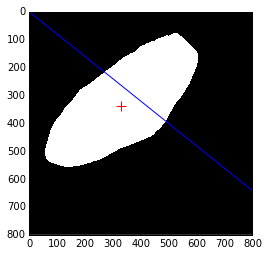

In [68]:
plt.plot(x, y)
plt.scatter(C_x, C_y, color='red', marker='+', s=100)
_ = plt.imshow(a, interpolation="none", cmap="gray")

## References

Some links which help me : 

- https://en.wikipedia.org/wiki/Image_moment
- https://github.com/shackenberg/Image-Moments-in-Python/blob/master/moments.py
- http://imagej.nih.gov/ij/source/ij/process/EllipseFitter.java
- http://imagej.1557.x6.nabble.com/Ellipse-fitting-algorithm-used-by-ImageJ-td3686611.html